In [1]:
import statsmodels.stats.multitest as multi
import statsmodels.api as sm

In [2]:
import seaborn as sns

In [3]:
import sys
sys.path.insert(0, "/cellar/users/mpagadal/Programs/anaconda3/lib/python3.7/site-packages")
from sklearn import linear_model
from regressors import stats

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Get data

In [28]:
raw=pd.read_csv("/nrnb/users/mpagadal/tcga-genotypes/germline-immune/hla.snp.raw",delim_whitespace=True)

In [29]:
cov=pd.read_csv("/cellar/users/mpagadal/Data/plink-associations/covs/immune.filt.cov",delimiter=" ")

In [30]:
combo_age=pd.merge(raw,cov,on="FID")

In [31]:
combo_age["6:29933439:T:C_T"]=combo_age["6:29933439:T:C_C"].map({2:0,1:1,0:2})

In [32]:
combo=[]

for i,row in combo_age.iterrows():
    if (row["6:29933439:T:C_T"]>0) & (row["6:29910358:G:C_C"]>0):
        combo.append(2)
    elif row["6:29933439:T:C_T"]>0:
        combo.append(1)
    elif row["6:29910358:G:C_C"]>0:
        combo.append(1)
    else:
        combo.append(0)
        
combo_age["combo"]=combo  

In [33]:
# map to cancer type
canc = pd.read_csv("/nrnb/users/mpagadal/tcga-genotypes/birdseed-processing/gtype.meta", delimiter="\t", header=None)
mp = canc.set_index(2)[0].to_dict()
combo_age["cancer"]=combo_age["FID"].map(mp)

In [34]:
combo_age=combo_age[combo_age["age"]!=-9]

In [35]:
cancers=combo_age["cancer"].unique()

In [36]:
pval=[]
canc=[]
beta=[]

for x in cancers:
    combo_age_cancer=combo_age[combo_age["cancer"]==x]
    ols = linear_model.LinearRegression()
    X=combo_age_cancer["combo"].values.reshape(-1, 1)
    y=combo_age_cancer["age"].values.reshape(-1, 1)
        
    X = sm.add_constant(X)
        
    model=sm.OLS(y,X)
    results=model.fit()
        
    canc.append(x)
    pval.append(results.pvalues[1])
    beta.append(results.params[1])

In [37]:
df=pd.DataFrame({"cancer":canc,"pval":pval,"beta":beta})

In [38]:
df=df.set_index("cancer")

In [39]:
order=['UVM',
 'KIRP',
 'STAD',
 'ESCA',
 'LIHC',
 'READ',
 'CHOL',
 'BRCA',
 'SKCM',
 'HNSC',
 'COAD',
 'LUSC',
 'MESO',
 'KIRC',
 'BLCA',
 'LUAD',
 'KICH',
 'PAAD',
 'ACC',
 'THCA']

In [40]:
df=df.loc[order]

In [41]:
df["age"]="age"

In [42]:
df["pval"]=-np.log10(df["pval"])

In [43]:
df=df.reset_index()

In [44]:
df.head()

,cancer,pval,beta,age
0,UVM,0.054766,-0.422187,age
1,KIRP,0.095735,0.300175,age
2,STAD,0.064312,-0.173776,age
3,ESCA,0.445968,-1.707010,age
4,LIHC,0.075909,0.360656,age


In [45]:
n_colors = 256 # Use 256 colors for the diverging color palette
palette = sns.diverging_palette(220, 20, n=n_colors) # Create the palette
color_min, color_max = [-10, 10] # Range of values that will be mapped to the palette, i.e. min and max possible correlation

def value_to_color(val):
    val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
    ind = int(val_position * (n_colors - 1)) # target index in the color palette
    return palette[ind]

-10


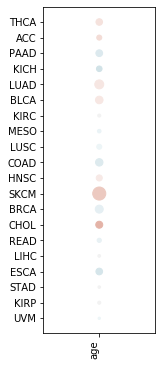

In [46]:
def heatmap(x, y, size,color):
    fig, ax = plt.subplots(figsize=(2, 6))
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in x.unique()]
    y_labels = [v for v in y.unique()]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    n_colors = 256 # Use 256 colors for the diverging color palette
    palette = sns.diverging_palette(20, 220, n=n_colors) # Create the palette
    color_min, color_max = [-10, 10] # Range of values that will be mapped to the palette, i.e. min and max possible correlation
    
    print(color_min)
    size_scale = 100
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, 
        c=color.apply(value_to_color)# Vector of square sizes, proportional to size parameter
        # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    plt.xticks(rotation=90)
    
heatmap(
    x=df['age'],
    y=df["cancer"],
    size=df["pval"].abs(),
    color=df["beta"]
)
plt.savefig("../plots/ols.age.pdf")